Model: "U_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/3000
[[7.24968767]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 7.2497
Epoch 2/3000
[[7.19409561]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 7.1941
Epoch 3/3000
[[7.1392293]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.1392
Epoch 4/3000
[[7.08525658]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7.0853
Epoch 5/3000
[[7.03237391]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.0324
Epoch 6/3000
[[6.98079824]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 6.9808
Epoch 7/3000
[[6.93077612]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.9308
Epoch 8/3000
[[6.88259411]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 6.8826
Epoch 9/3000
[[6.83658361]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.8366
Epoch 10/3000
[[6.79311943]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.7931
Epoch 11/3000
[[6.75261688]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.7526
Epoch 12/3000
[[6.71552]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.7155
Epoch 13/3000
[[6.6822834]]
1/

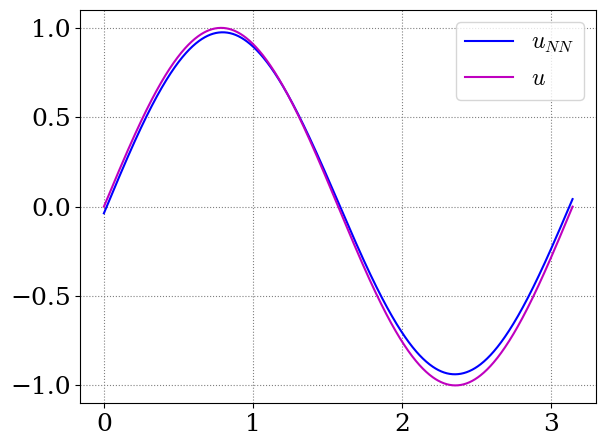

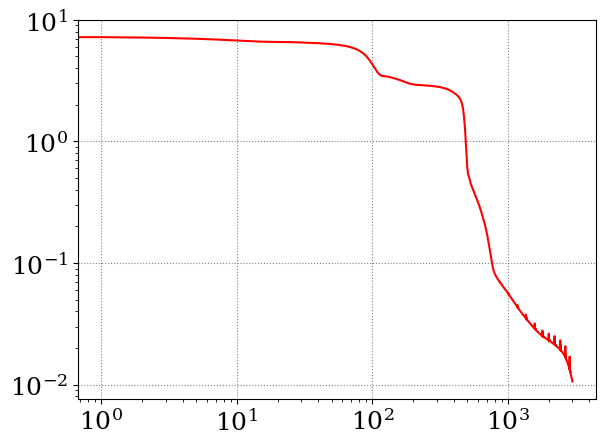

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Define the number of neurons per layer
NN = 10
# Define the number of layers
NL = 5
# Define number of collocation points
N_points = 100
# Define the number of epochs
N_epoch = 3000

# Define the source function of the PDE -Δu = f
def f_source(x):
    return -4 * tf.sin(2 * x)

# Define the exact solution for comparison
def uexact(x):
    return tf.sin(2 * x)

# Input layer (dummy input for the network)
X = tf.keras.layers.Input(shape=(1,))

# Define the first layer with a 'tanh' activation function
L1 = tf.keras.layers.Dense(units=NN, activation='tanh')(X)

# Add hidden layers in a loop (excluding first and last layers)
for l in range(NL - 2):
    L1 = tf.keras.layers.Dense(units=NN, activation='tanh')(L1)

# Last layer with a single output (for a scalar PDE solution)
LO = tf.keras.layers.Dense(units=1, activation='tanh')(L1)

# Assemble the neural network model
U_model = tf.keras.Model(inputs=X, outputs=LO, name='U_model')

# Print the model summary
U_model.summary()

# Define a custom loss class for the PDE
###############################################################################
# Parameters for the class "loss":
#   U_model   --> Neural Network Architecture (the model representing u)
#   N_points  --> Number of sampled points across the problem's domain
#   f_source  --> Source function of the PDE -Δu = f
###############################################################################
class loss(tf.keras.layers.Layer):
    def __init__(self, U_model, N_points, f_source, **kwargs):
        super(loss, self).__init__()
        self.U_model = U_model  # Neural network model
        self.N_points = N_points  # Number of collocation points
        self.f_source = f_source  # Source function

    # Compute the second derivative of the neural network solution U_nn
    def call(self, inputs):
        # Sample points in the domain [0, pi]
        S = tf.experimental.numpy.linspace(0., np.pi, num=self.N_points, dtype='float32')
        
        # Compute the second derivative using nested GradientTapes
        with tf.GradientTape(persistent=True) as t1:
            t1.watch(S)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(S)
                ueval = U_model(S)  # Evaluate neural network at S
                u_x = t2.gradient(ueval, S)  # First derivative
            u_xx = t1.gradient(u_x, S)  # Second derivative
        
        # Compute the residual loss (L2-norm of PDE residual)
        f_source = self.f_source(S)  # Evaluate source term at S
        loss_out = tf.math.reduce_mean((u_xx - f_source) ** 2)
        
        # Add boundary conditions (u(0) = 0, u(pi) = 0)
        loss_out += self.U_model(np.array([0.]))**2 + self.U_model(np.array([np.pi]))**2
        
        # Print loss for each iteration (optional)
        tf.print(loss_out)
        
        return loss_out    

# Function to create a loss model using the custom loss layer
def loss_model(U_model, N_points, f_source):
    Xl = tf.keras.layers.Input(shape=(1,))
    loss_layer = loss(U_model, N_points, f_source)(Xl)
    loss_f = tf.keras.Model(inputs=Xl, outputs=loss_layer)
    return loss_f

# A simple loss function for the training process
def loss_value(x, y):
    return y

# Assemble the full model (PDE solver using neural network)
model_all = loss_model(U_model, N_points, f_source)
optimizer = tf.keras.optimizers.Adam(learning_rate=10**-3)  # Optimizer (Adam)
model_all.compile(optimizer=optimizer, loss=loss_value)  # Compile with custom loss

# Train the model
history = model_all.fit(np.array([1.]), np.array([1.]), epochs=N_epoch)

# Matplotlib settings for nice plots
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 18
rcParams['legend.fontsize'] = 17
rcParams['mathtext.fontset'] = 'cm' 
rcParams['axes.labelsize'] = 19

# Generate a list of x values for visualization
xlist = tf.experimental.numpy.linspace(0., np.pi, num=1000, dtype='float32')

## ---------
# Plot the Solution
## ---------
fig, ax = plt.subplots()
# Plot the approximate solution (neural network prediction)
plt.plot(xlist, U_model(xlist), color='b')
# Plot the exact solution for comparison
plt.plot(xlist, uexact(xlist), color='m')
# Add legend
plt.legend(['$u_{NN}$', '$u$'])

# Display grid and show plot
ax.grid(which='both', axis='both', linestyle=':', color='gray')
plt.tight_layout()
plt.show()

# Plot the loss evolution over epochs
Loss_rel = history.history['loss'] 
fig, ax = plt.subplots()
# Plot the loss curve
plt.plot(Loss_rel, color='r')

# Set logarithmic scale for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Display grid and show plot
ax.grid(which='major', axis='both', linestyle=':', color='gray')
plt.tight_layout()
plt.show()


